# **European Drug Development**

Team members: Wen-Hsin Kung, Tzu-Chun Chen, Angela Liou

[[Data Source](http://github.com/rfordatascience/tidytuesday/tree/main/data/2023/2023-03-14)]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import .csv data
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/drugs.csv')
data.head()

,category,medicine_name,therapeutic_area,common_name,active_substance,product_number,patient_safety,authorisation_status,atc_code,additional_monitoring,...,marketing_authorisation_holder_company_name,pharmacotherapeutic_group,date_of_opinion,decision_date,revision_number,condition_indication,species,first_published,revision_date,url
0,human,Adcetris,"Lymphoma, Non-Hodgkin; Hodgkin Disease",brentuximab vedotin,brentuximab vedotin,2455,False,authorised,L01XC12,False,...,Takeda Pharma A/S,Antineoplastic agents,2012-07-19,2022-11-17,34.0,Hodgkin lymphomaAdcetris is indicated for adul...,NaN,2018-07-25T13:58:00Z,2023-03-13T11:52:00Z,https://www.ema.europa.eu/en/medicines/human/E...
1,human,Nityr,Tyrosinemias,nitisinone,nitisinone,4582,False,authorised,A16AX04,False,...,Cycle Pharmaceuticals (Europe) Ltd,"Other alimentary tract and metabolism products,",2018-05-31,2023-03-10,4.0,Treatment of adult and paediatric patients wit...,NaN,2018-07-26T14:20:00Z,2023-03-10T17:29:00Z,https://www.ema.europa.eu/en/medicines/human/E...
2,human,Ebvallo,Lymphoproliferative Disorders,tabelecleucel,tabelecleucel,4577,False,authorised,NaN,True,...,Pierre Fabre Medicament,NaN,2022-10-13,2023-03-09,2.0,Ebvallo is indicated as monotherapy for treatm...,NaN,2022-10-12T16:13:00Z,2023-03-10T13:40:00Z,https://www.ema.europa.eu/en/medicines/human/E...
3,human,Ronapreve,COVID-19 virus infection,"casirivimab, imdevimab","casirivimab, imdevimab",5814,False,authorised,J06BD,True,...,Roche Registration GmbH,"Immune sera and immunoglobulins,",2021-11-11,2023-02-24,3.0,Ronapreve is indicated for:Treatment of COVID-...,NaN,2021-11-12T16:30:00Z,2023-03-10T12:29:00Z,https://www.ema.europa.eu/en/medicines/human/E...
4,human,Cosentyx,"Arthritis, Psoriatic; Psoriasis; Spondylitis...",secukinumab,secukinumab,3729,False,authorised,L04AC10,False,...,Novartis Europharm Limited,Immunosuppressants,2014-11-20,2023-01-26,30.0,Plaque psoriasisCosentyx is indicated for the ...,NaN,2018-06-07T11:59:00Z,2023-03-09T18:53:00Z,https://www.ema.europa.eu/en/medicines/human/E...


Q2: Does additional monitoring act as a central regulatory feature around which other special designations (e.g., orphan status, conditional approval, exceptional circumstances) tend to co-occur, forming a distinct subgroup of medicines?

In [ ]:
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact

flags = [
    'additional_monitoring',
    'orphan_medicine',
    'conditional_approval',
    'exceptional_circumstances',
    'accelerated_assessment'
]

df = data[flags].copy()
df = df.replace({True:1, False:0})
df = df.apply(pd.to_numeric, errors='coerce').dropna()

A = 'additional_monitoring'
targets = [c for c in flags if c != A]

rows = []
for B in targets:
    p_b_given_a1 = df.loc[df[A]==1, B].mean()
    p_b_given_a0 = df.loc[df[A]==0, B].mean()
    p_b = df[B].mean()
    lift = (p_b_given_a1 / p_b) if p_b > 0 else np.nan

    # 2x2 table
    tab = pd.crosstab(df[A], df[B])
    # if any expected < 5 -> Fisher is safer
    chi2, p_chi, _, expected = chi2_contingency(tab)
    use_fisher = (expected < 5).any()
    if use_fisher:
        # fisher expects [[a,b],[c,d]] with both rows/cols present
        tab2 = tab.reindex(index=[0,1], columns=[0,1], fill_value=0)
        _, p_fisher = fisher_exact(tab2.values)
        p_val = p_fisher
        test = "Fisher"
    else:
        p_val = p_chi
        test = "Chi-square"

    rows.append({
        "flag": B,
        "P(B=1|A=1)": p_b_given_a1,
        "P(B=1|A=0)": p_b_given_a0,
        "Lift": lift,
        "p_value": p_val
    })

result = pd.DataFrame(rows).sort_values("Lift", ascending=False)
result


/tmp/ipython-input-2384718848.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True:1, False:0})


,flag,P(B=1|A=1),P(B=1|A=0),Lift,p_value
1,conditional_approval,0.113695,0.002498,4.708872,1.999845e-36
2,exceptional_circumstances,0.090439,0.008120,3.745693,1.646383e-20
0,orphan_medicine,0.260982,0.038101,3.202667,2.973816e-46
3,accelerated_assessment,0.025840,0.023735,1.070198,9.541122e-01


/tmp/ipython-input-82867210.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


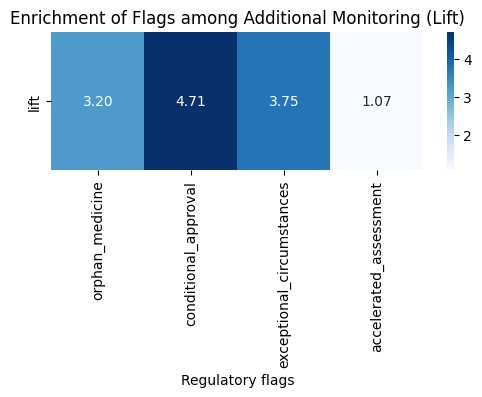

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

A = 'additional_monitoring'
targets = ['orphan_medicine', 'conditional_approval', 'exceptional_circumstances', 'accelerated_assessment']

rows = []
for B in targets:
    p_b = df[B].mean()
    p_b_given_a1 = df.loc[df[A]==1, B].mean()
    lift = (p_b_given_a1 / p_b) if p_b > 0 else np.nan
    rows.append([B, lift])

lift_df = pd.DataFrame(rows, columns=["flag", "lift"]).set_index("flag")

plt.figure(figsize=(6, 1.8))
sns.heatmap(lift_df.T, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Enrichment of Flags among Additional Monitoring (Lift)")
plt.xlabel("Regulatory flags")
plt.ylabel("")
plt.tight_layout()
plt.show()


Insight: To test whether additional monitoring functions as a “central” regulatory feature, we compared how often other special designations appear when additional monitoring is present versus absent. The results show a clear co-occurrence pattern: medicines with additional monitoring are much more likely to also receive conditional approval (11.4% vs 0.25%, lift ≈ 4.71), exceptional circumstances (9.0% vs 0.81%, lift ≈ 3.75), and orphan designation (26.1% vs 3.8%, lift ≈ 3.20). All three differences are highly significant (very small p-values), suggesting these co-occurrences are not random. In contrast, accelerated assessment does not show the same behavior (2.58% vs 2.37%, lift ≈ 1.07; p ≈ 0.95), which implies it may represent a different pathway that is not specifically tied to additional monitoring. Overall, the evidence supports the idea that additional monitoring acts as a hub-like signal around which several “special pathway” designations cluster.